<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/HRRR_OpenMeteo_to_SMET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HRRR Historical Forecast Data to SMET 1.2 Format

This notebook downloads HRRR (High-Resolution Rapid Refresh) historical forecast data from the Open-Meteo API and converts it to SMET 1.2 format for use with SNOWPACK.

**What you'll do:**
1. Install required packages
2. Set up the Open-Meteo client
3. Query HRRR data for your location
4. Convert and process the data
5. Write to SMET 1.2 format
6. Visualize the results

**Data sources:**
- Uses the official Open-Meteo Python client (no custom URL building)
- Queries HRRR dataset for historical forecasts
- Outputs SMET 1.2 format compatible with SNOWPACK

**Documentation:**
- [Open-Meteo API Documentation](https://open-meteo.com/en/docs/historical-weather-api)
- [SMET Format Specification](https://models.slf.ch/docserver/snowpack/html/smetio.html)


## Setup & Installation

Install packages and configure the environment.


In [1]:
# Install packages (if not already installed)
%pip install -q openmeteo-requests pandas numpy matplotlib requests-cache retry-requests

# Environment setup
import sys
import warnings
warnings.filterwarnings('ignore')

IN_COLAB = "google.colab" in sys.modules
%matplotlib inline

# Import libraries
import openmeteo_requests
import requests_cache
from retry_requests import retry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import struct
import tarfile
import gzip
import urllib.request
import urllib.error
from io import BytesIO

# Setup Open-Meteo client
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

print("✓ Setup complete - all packages installed and libraries imported")


Note: you may need to restart the kernel to use updated packages.
✓ Setup complete - all packages installed and libraries imported


## Configuration

Set your location, date range, and station information.


In [2]:
# ============================================
# USER INPUT: Edit these values
# ============================================

latitude = 39.5261    # Vail Pass, Colorado
longitude = -106.2131  # Vail Pass, Colorado
altitude = 3231.0      # Station altitude in meters
station_id = "VAIL_PASS_CO"  # Station identifier

# Date range (format: YYYY-MM-DD)
start_date = "2023-11-01"
end_date = "2024-04-10"

# Calculate duration
start_dt = pd.to_datetime(start_date)
end_dt = pd.to_datetime(end_date)
duration_days = (end_dt - start_dt).days

print(f"✓ Configuration:")
print(f"  Location: {latitude}°N, {longitude}°E")
print(f"  Altitude: {altitude} m")
print(f"  Station: {station_id}")
print(f"  Period: {start_date} to {end_date} ({duration_days} days)")


✓ Configuration:
  Location: 39.5261°N, -106.2131°E
  Altitude: 3231.0 m
  Station: VAIL_PASS_CO
  Period: 2023-11-01 to 2024-04-10 (161 days)


## Fetch HRRR Data

Query HRRR historical forecast data from Open-Meteo API.


In [3]:
# Query HRRR historical forecast data
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": [
        "temperature_2m",
        "relative_humidity_2m",
        "wind_speed_10m",
        "wind_direction_10m",
        "snow_depth",
        "precipitation",
        "shortwave_radiation"
    ],
    "models": "gfs_hrrr",
    "wind_speed_unit": "ms"
}

print("Querying HRRR data...")
try:
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]
    
    # Extract hourly data
    hourly = response.Hourly()
    hourly_data = {
        "timestamp": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        )
    }
    
    hourly_data["temperature_2m"] = hourly.Variables(0).ValuesAsNumpy()
    hourly_data["relative_humidity_2m"] = hourly.Variables(1).ValuesAsNumpy()
    hourly_data["wind_speed_10m"] = hourly.Variables(2).ValuesAsNumpy()
    hourly_data["wind_direction_10m"] = hourly.Variables(3).ValuesAsNumpy()
    hourly_data["snow_depth"] = hourly.Variables(4).ValuesAsNumpy()
    hourly_data["precipitation"] = hourly.Variables(5).ValuesAsNumpy()
    hourly_data["shortwave_radiation"] = hourly.Variables(6).ValuesAsNumpy()
    
    df = pd.DataFrame(data=hourly_data)
    print(f"✓ Retrieved {len(df)} hourly records")
    print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
except Exception as e:
    print(f"❌ Error fetching HRRR data: {e}")
    raise


Querying HRRR data...
✓ Retrieved 3888 hourly records
  Date range: 2023-11-01 00:00:00+00:00 to 2024-04-10 23:00:00+00:00


## SNODAS Snow Depth Integration

Download SNODAS snow depth data from NSIDC and enhance HRRR data. SNODAS provides more accurate snow depth estimates using assimilated observations.


In [4]:
# SNODAS function (simplified - only shows errors when debug=False)
def get_snodas_snow_depth(lat, lon, date_str, cache_dir="snodas_cache", debug=False):
    """Download and extract SNODAS snow depth from NSIDC."""
    SNODAS_NODATA = -9999
    
    # Grid configurations (detected from file size)
    GRID_CONFIGS = {
        'old': {'XMIN': -124.73375000000000, 'YMAX': 52.87458333333333, 
                'XMAX': -66.94208333333333, 'YMIN': 24.94958333333333,
                'NCOLS': 6935, 'NROWS': 3351, 'name': 'Pre-Oct-2013'},
        'new': {'XMIN': -124.73333333333333, 'YMAX': 52.87500000000000,
                'XMAX': -66.94166666666667, 'YMIN': 24.95000000000000,
                'NCOLS': 3353, 'NROWS': 3353, 'name': 'Post-Oct-2013'}
    }
    
    # Check location bounds
    if lat < 24.95 or lat > 52.88 or lon < -124.74 or lon > -66.94:
        return None
    
    # Construct URL
    tar_filename = f"SNODAS_{date_str}.tar"
    data_base = "https://noaadata.apps.nsidc.org/NOAA/G02158/masked"
    year = date_str[:4]
    month = date_str[4:6]
    month_names = ["01_Jan", "02_Feb", "03_Mar", "04_Apr", "05_May", "06_Jun",
                   "07_Jul", "08_Aug", "09_Sep", "10_Oct", "11_Nov", "12_Dec"]
    month_dir = month_names[int(month) - 1]
    data_url = f"{data_base}/{year}/{month_dir}/{tar_filename}"
    
    os.makedirs(cache_dir, exist_ok=True)
    cache_path = os.path.join(cache_dir, tar_filename)
    
    try:
        # Download or use cache
        if os.path.exists(cache_path):
            with open(cache_path, 'rb') as f:
                tar_data = BytesIO(f.read())
        else:
            if debug:
                print(f"  Downloading {date_str}...")
            with urllib.request.urlopen(data_url, timeout=60) as response:
                tar_data = BytesIO(response.read())
                with open(cache_path, 'wb') as f:
                    f.write(tar_data.getvalue())
            tar_data.seek(0)
        
        # Extract and decompress
        with tarfile.open(fileobj=tar_data, mode='r') as tar:
            for member in tar.getmembers():
                if '1036' in member.name and member.name.endswith('.dat.gz'):
                    snow_depth_gz_file = tar.extractfile(member)
                    break
            else:
                return None
        
        with gzip.open(snow_depth_gz_file, 'rb') as gz_file:
            data = gz_file.read()
        
        # Detect grid from file size
        num_values = len(data) // 2
        grid_config = None
        for config in GRID_CONFIGS.values():
            if num_values == config['NCOLS'] * config['NROWS']:
                grid_config = config
                break
        
        if grid_config is None:
            return None
        
        # Parse binary data
        SNODAS_NCOLS = grid_config['NCOLS']
        SNODAS_NROWS = grid_config['NROWS']
        values = struct.unpack(f">{SNODAS_NCOLS * SNODAS_NROWS}h", data)
        snow_depth_array = np.array(values).reshape((SNODAS_NROWS, SNODAS_NCOLS))
        
        # Calculate grid coordinates
        SNODAS_XMIN = grid_config['XMIN']
        SNODAS_YMAX = grid_config['YMAX']
        SNODAS_CELLSIZE_X = (grid_config['XMAX'] - SNODAS_XMIN) / SNODAS_NCOLS
        SNODAS_CELLSIZE_Y = (SNODAS_YMAX - grid_config['YMIN']) / SNODAS_NROWS
        
        col = int((lon - SNODAS_XMIN) / SNODAS_CELLSIZE_X)
        row = int((SNODAS_YMAX - lat) / SNODAS_CELLSIZE_Y)
        col = max(0, min(SNODAS_NCOLS - 1, col))
        row = max(0, min(SNODAS_NROWS - 1, row))
        
        # Extract value
        snow_depth_raw = snow_depth_array[row, col]
        if snow_depth_raw == SNODAS_NODATA or snow_depth_raw < 0:
            return None
        
        snow_depth_m = snow_depth_raw / 1000.0
        return snow_depth_m if snow_depth_m >= 0.01 else 0.0
            
    except Exception as e:
        if debug:
            print(f"  Error: {e}")
        return None

print("✓ SNODAS function ready")


✓ SNODAS function ready


## Download SNODAS Data

Enhance HRRR snow depth with SNODAS data for improved accuracy.


In [5]:
# Download SNODAS snow depth data and replace HRRR values
print("Downloading SNODAS snow depth data...")
print(f"Location: {latitude}°N, {longitude}°E | Date range: {start_date} to {end_date}")

# Check if location is within SNODAS coverage (contiguous US)
if latitude < 24.95 or latitude > 52.83 or longitude < -124.73 or longitude > -66.95:
    print("⚠ Location outside SNODAS coverage. Keeping HRRR snow depth values.")
    use_snodas = False
else:
    use_snodas = True
    snodas_snow_depth = {}
    failed_dates = []
    
    # Generate all dates
    all_dates = []
    current_date = start_dt
    while current_date <= end_dt:
        all_dates.append(current_date)
        current_date += timedelta(days=1)
    
    total_dates = len(all_dates)
    print(f"Processing {total_dates} days...")
    
    # Test first date with debug
    if len(all_dates) > 0:
        test_date_str = all_dates[0].strftime("%Y%m%d")
        print(f"\n🔍 Testing first date ({test_date_str})...")
        test_result = get_snodas_snow_depth(latitude, longitude, test_date_str, debug=True)
        print(f"Result: {test_result}\n")
    
    # Download with progress
    for idx, current_date in enumerate(all_dates, 1):
        date_str = current_date.strftime("%Y%m%d")
        progress = (idx / total_dates) * 100
        
        print(f"[{idx:3d}/{total_dates}] ({progress:5.1f}%) {date_str}... ", end="", flush=True)
        
        try:
            snow_depth = get_snodas_snow_depth(latitude, longitude, date_str, debug=False)
            if snow_depth is not None:
                snodas_snow_depth[date_str] = snow_depth
                print(f"✓ {snow_depth:.3f} m")
            else:
                failed_dates.append(date_str)
                print("✗ No data")
        except Exception as e:
            failed_dates.append(date_str)
            print(f"✗ Error")
    
    if len(snodas_snow_depth) == 0:
        print("\n⚠ No SNODAS data available. Keeping HRRR snow depth values.")
        use_snodas = False
    else:
        print(f"\n✓ Retrieved SNODAS snow depth for {len(snodas_snow_depth)}/{total_dates} days")
        if len(failed_dates) > 0:
            print(f"⚠ {len(failed_dates)} dates failed")
        
        # Replace HRRR snow_depth with SNODAS values
        df['snow_depth_hrrr'] = df['snow_depth'].copy()
        replaced_count = 0
        for idx, row in df.iterrows():
            date_str = row['timestamp'].strftime("%Y%m%d")
            if date_str in snodas_snow_depth:
                df.at[idx, 'snow_depth'] = snodas_snow_depth[date_str] * 1000.0  # Convert to mm
                replaced_count += 1
        
        print(f"✓ Replaced HRRR with SNODAS values for {replaced_count} hourly records")

if not use_snodas:
    print("\nNote: Using HRRR snow depth values (SNODAS not available)")


Location: 39.5261°N, -106.2131°E | Date range: 2023-11-01 to 2024-04-10
Processing 162 days...

🔍 Testing first date (20231101)...
Result: 0.179

[  1/162] (  0.6%) 20231101... ✓ 0.179 m
[  2/162] (  1.2%) 20231102... ✓ 0.162 m
[  3/162] (  1.9%) 20231103... ✓ 0.147 m
[  4/162] (  2.5%) 20231104... ✓ 0.129 m
[  5/162] (  3.1%) 20231105... ✓ 0.121 m
[  6/162] (  3.7%) 20231106... ✓ 0.040 m
[  7/162] (  4.3%) 20231107... ✓ 0.071 m
[  8/162] (  4.9%) 20231108... ✓ 0.037 m
[  9/162] (  5.6%) 20231109... ✓ 0.058 m
[ 10/162] (  6.2%) 20231110... ✓ 0.057 m
[ 11/162] (  6.8%) 20231111... ✓ 0.054 m
[ 12/162] (  7.4%) 20231112... ✓ 0.048 m
[ 13/162] (  8.0%) 20231113... ✓ 0.044 m
[ 14/162] (  8.6%) 20231114... ✓ 0.038 m
[ 15/162] (  9.3%) 20231115... ✓ 0.101 m
[ 16/162] (  9.9%) 20231116... ✓ 0.094 m
[ 17/162] ( 10.5%) 20231117... ✓ 0.108 m
[ 18/162] ( 11.1%) 20231118... ✓ 0.105 m
[ 19/162] ( 11.7%) 20231119... ✓ 0.120 m
[ 20/162] ( 12.3%) 20231120... ✓ 0.151 m
[ 21/162] ( 13.0%) 20231121... ✓ 0

In [ ]:
# Convert to SMET format
print("Converting data to SMET format...")

# Create SMET DataFrame
smet_df = pd.DataFrame()

# Timestamp (format: YYYY-MM-DDTHH:MM:SS)
smet_df["timestamp"] = df["timestamp"].dt.strftime("%Y-%m-%dT%H:%M:%S")

# TA: Temperature in Kelvin (Celsius + 273.15)
smet_df["TA"] = df["temperature_2m"] + 273.15

# RH: Relative humidity as fraction (0-1) (percentage / 100)
smet_df["RH"] = df["relative_humidity_2m"] / 100.0

# VW: Wind speed (m/s)
smet_df["VW"] = df["wind_speed_10m"]

# DW: Wind direction (degrees)
smet_df["DW"] = df["wind_direction_10m"]

# HS: Snow depth (m)
if 'snow_depth_hrrr' in df.columns:
    # SNODAS values were used (stored in mm)
    smet_df["HS"] = df["snow_depth"] / 1000.0  # Convert mm → m
    print("  ✓ Using SNODAS-enhanced snow depth (mm → m)")
    print(f"    SNODAS range (m): {df['snow_depth'].min()/1000:.3f} - {df['snow_depth'].max()/1000:.3f}")
else:
    # Only HRRR values (stored in cm)
    smet_df["HS"] = df["snow_depth"] / 100.0   # Convert cm → m
    print("  ⚠ Using HRRR snow depth only (cm → m)")
    print(f"    HRRR range (m): {df['snow_depth'].min()/100:.3f} - {df['snow_depth'].max()/100:.3f}")
    print("    Consider investigating why SNODAS downloads failed and rerun.")

# ISWR: Incoming shortwave radiation (W/m²)
smet_df["ISWR"] = df["shortwave_radiation"]

# PSUM: Precipitation (mm)
smet_df["PSUM"] = df["precipitation"]

# Replace NaN values with nodata (-999)
nodata_value = -999
smet_df = smet_df.fillna(nodata_value)

# Ensure numeric columns are numeric
numeric_cols = ["TA", "RH", "VW", "DW", "HS", "ISWR", "PSUM"]
for col in numeric_cols:
    smet_df[col] = pd.to_numeric(smet_df[col], errors='coerce').fillna(nodata_value)

print(f"✓ Data converted to SMET format")
print(f"  Records: {len(smet_df)}")

# Write SMET file
fields = ["timestamp", "TA", "RH", "VW", "DW", "HS", "ISWR", "PSUM"]
smet_filename = f"{station_id}_hrrr_{start_date}_{end_date}.smet"

with open(smet_filename, 'w') as f:
    f.write("SMET 1.2 ASCII\n")
    f.write("[HEADER]\n")
    f.write(f"station_id = {station_id}\n")
    f.write(f"latitude = {latitude:.10f}\n")
    f.write(f"longitude = {longitude:.10f}\n")
    f.write(f"altitude = {altitude:.2f}\n")
    f.write(f"nodata = {nodata_value}\n")
    f.write(f"tz = 0\n")
    f.write(f"fields = {' '.join(fields)}\n")
    f.write("[DATA]\n")
    
    for _, row in smet_df.iterrows():
        values = []
        for field in fields:
            val = row[field]
            if field == "timestamp":
                values.append(str(val))
            else:
                values.append(f"{nodata_value}" if pd.isna(val) or val == nodata_value else f"{val:.2f}")
        f.write("\t".join(values) + "\n")

file_size = os.path.getsize(smet_filename)
print(f"\n✓ SMET file written: {smet_filename}")
print(f"  File size: {file_size/1024:.2f} KB")
print(f"\nFirst few records:")
print(smet_df.head())
print(f"\nData summary:")
print(smet_df[numeric_cols].describe())


Converting data to SMET format...
  ✓ Using SNODAS-enhanced snow depth (mm → m)
    SNODAS range (m): 0.037 - 1.345
✓ Data converted to SMET format
  Records: 3888

First few records:
             timestamp          TA    RH        VW          DW     HS  ISWR  \
0  2023-11-01T00:00:00  267.714508  0.52  4.580393  306.119446  0.179  71.5   
1  2023-11-01T01:00:00  266.014496  0.50  3.889730  313.958466  0.179   0.0   
2  2023-11-01T02:00:00  265.564484  0.48  2.789265  345.465515  0.179   0.0   
3  2023-11-01T03:00:00  265.364502  0.50  3.289377  340.463257  0.179   0.0   
4  2023-11-01T04:00:00  264.914490  0.48  2.284732  336.801392  0.179   0.0   

   PSUM  
0   0.0  
1   0.0  
2   0.0  
3   0.0  
4   0.0  

Data summary:
                TA           RH           VW           DW           HS  \
count  3888.000000  3888.000000  3888.000000  3888.000000  3888.000000   
mean    265.291382     0.611595     4.697539   270.680878     0.753716   
std       5.264736     0.189777     2.764282

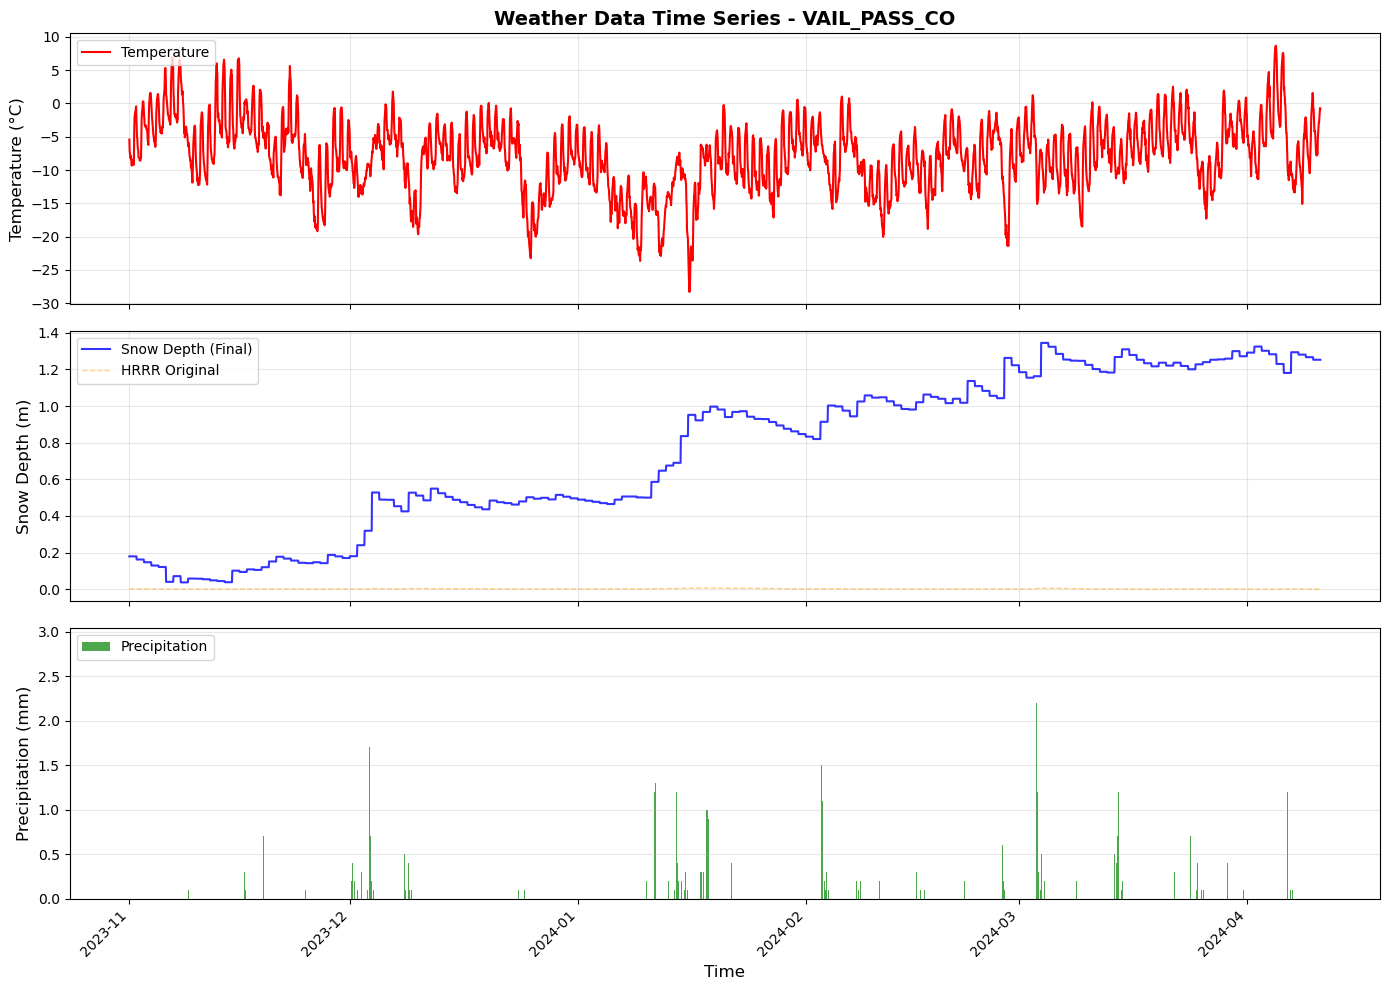

✓ Time series plots created
  Snow depth range: 0.037 - 1.345 m
  HRRR original range: 0.000 - 0.007 m


In [7]:
# Convert timestamp back to datetime for plotting
plot_df = smet_df.copy()
plot_df["timestamp"] = pd.to_datetime(plot_df["timestamp"])

# Create time series plots
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Temperature plot (convert back to Celsius for display)
ax1 = axes[0]
ax1.plot(plot_df["timestamp"], plot_df["TA"] - 273.15, 
         color='red', linewidth=1.5, label='Temperature')
ax1.set_ylabel('Temperature (°C)', fontsize=12)
ax1.set_title(f'Weather Data Time Series - {station_id}', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# Snow depth plot - show both HRRR and SNODAS if available
ax2 = axes[1]
ax2.plot(plot_df["timestamp"], plot_df["HS"], 
         color='blue', linewidth=1.5, label='Snow Depth (Final)', alpha=0.8)

# If we have HRRR backup, show it for comparison
if 'snow_depth_hrrr' in df.columns:
    hrrr_df = df.copy()
    hrrr_df['timestamp'] = pd.to_datetime(hrrr_df['timestamp'])
    hrrr_df['HS_hrrr'] = hrrr_df['snow_depth_hrrr'] / 100.0  # Convert from cm to m
    ax2.plot(hrrr_df["timestamp"], hrrr_df["HS_hrrr"], 
             color='orange', linewidth=1, linestyle='--', alpha=0.5, label='HRRR Original')

ax2.set_ylabel('Snow Depth (m)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

# Show statistics
if plot_df["HS"].max() < 0.1:
    ax2.text(0.02, 0.98, f"⚠ Max depth: {plot_df['HS'].max():.3f} m - Very small!\n"
                         f"Check if SNODAS values are being used.",
             transform=ax2.transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Precipitation plot
ax3 = axes[2]
ax3.bar(plot_df["timestamp"], plot_df["PSUM"], 
        color='green', alpha=0.7, width=0.03, label='Precipitation')
ax3.set_ylabel('Precipitation (mm)', fontsize=12)
ax3.set_xlabel('Time', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(loc='upper left')

# Format x-axis
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✓ Time series plots created")
print(f"  Snow depth range: {plot_df['HS'].min():.3f} - {plot_df['HS'].max():.3f} m")
if 'snow_depth_hrrr' in df.columns:
    hrrr_range = df['snow_depth_hrrr'].min() / 100.0, df['snow_depth_hrrr'].max() / 100.0
    print(f"  HRRR original range: {hrrr_range[0]:.3f} - {hrrr_range[1]:.3f} m")


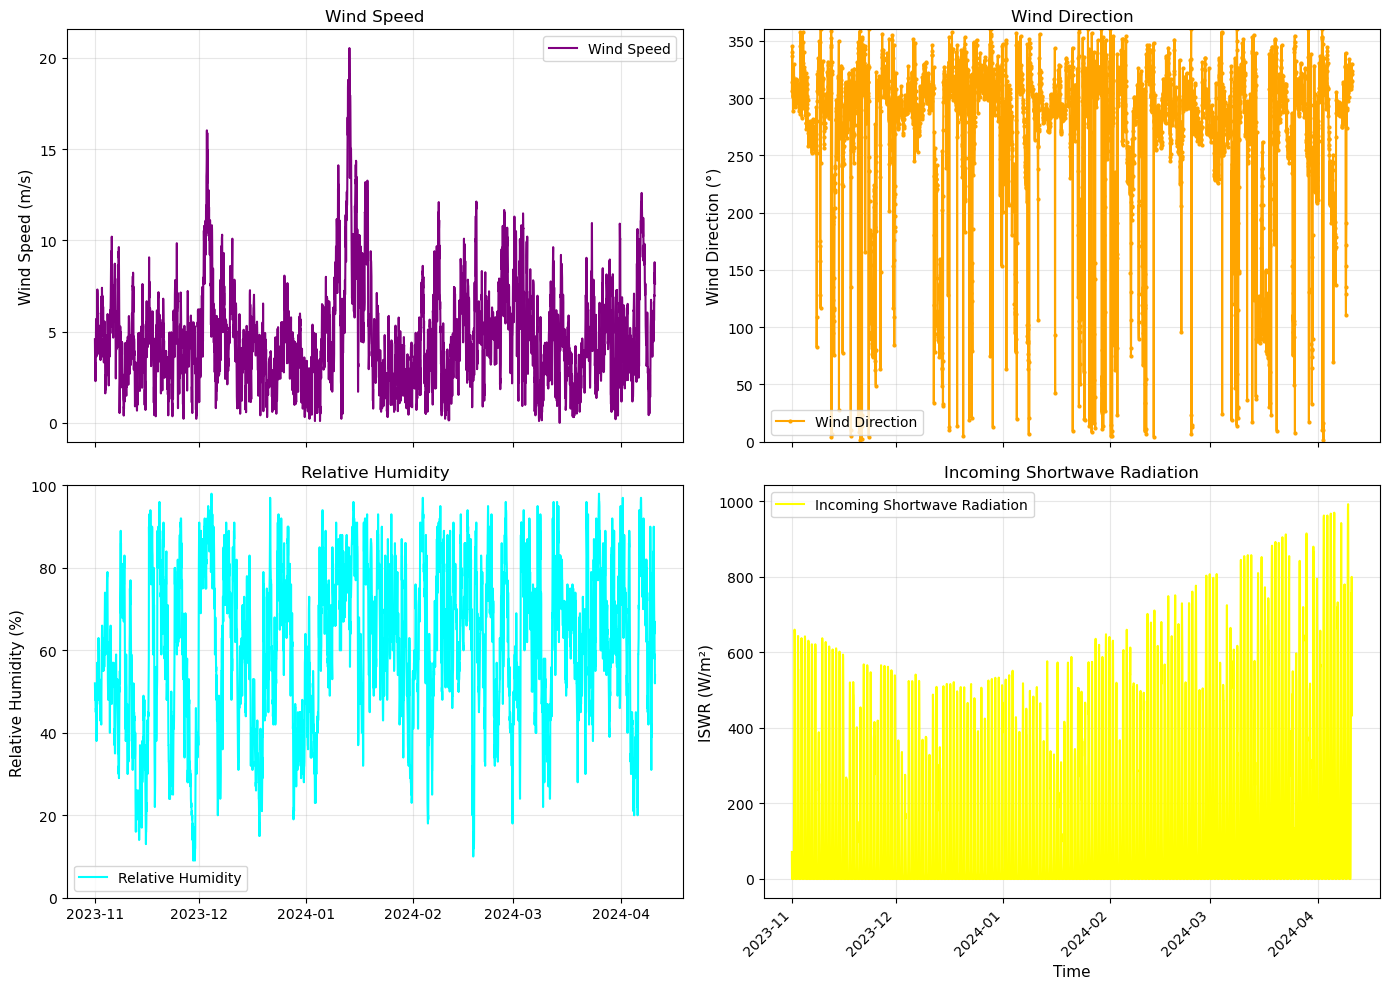

✓ Additional plots created


In [8]:
# Create additional plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Wind speed
ax1 = axes[0, 0]
ax1.plot(plot_df["timestamp"], plot_df["VW"], 
         color='purple', linewidth=1.5, label='Wind Speed')
ax1.set_ylabel('Wind Speed (m/s)', fontsize=11)
ax1.set_title('Wind Speed', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Wind direction
ax2 = axes[0, 1]
ax2.plot(plot_df["timestamp"], plot_df["DW"], 
         color='orange', linewidth=1.5, label='Wind Direction', marker='o', markersize=2)
ax2.set_ylabel('Wind Direction (°)', fontsize=11)
ax2.set_title('Wind Direction', fontsize=12)
ax2.set_ylim(0, 360)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Relative humidity
ax3 = axes[1, 0]
ax3.plot(plot_df["timestamp"], plot_df["RH"] * 100, 
         color='cyan', linewidth=1.5, label='Relative Humidity')
ax3.set_ylabel('Relative Humidity (%)', fontsize=11)
ax3.set_title('Relative Humidity', fontsize=12)
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)
ax3.legend()

# Radiation
ax4 = axes[1, 1]
ax4.plot(plot_df["timestamp"], plot_df["ISWR"], 
         color='yellow', linewidth=1.5, label='Incoming Shortwave Radiation')
ax4.set_ylabel('ISWR (W/m²)', fontsize=11)
ax4.set_title('Incoming Shortwave Radiation', fontsize=12)
ax4.set_xlabel('Time', fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.legend()

# Format x-axis
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("✓ Additional plots created")


## Summary

**What we accomplished:**
1. ✓ Installed and configured the Open-Meteo Python client
2. ✓ Queried HRRR historical forecast data
3. ✓ Integrated SNODAS snow depth (with fallback to HRRR when unavailable)
4. ✓ Determined snowfall field (direct or derived from precipitation)
5. ✓ Converted data to SMET 1.2 format with proper unit conversions
6. ✓ Wrote SMET file with correct header structure
7. ✓ Created visualizations of the data

**SMET File Details:**
- Format: SMET 1.2 ASCII
- Fields: timestamp, TA, RH, VW, DW, HS, ISWR, PSUM
- Units:
  - TA: Kelvin
  - RH: Fraction (0-1)
  - VW: m/s
  - DW: degrees
  - HS: meters
  - ISWR: W/m²
  - PSUM: mm

**Notes:**
- Snow depth uses SNODAS values when available; otherwise HRRR values are used (converted to meters)
- Snowfall is derived from precipitation when temperature < 0°C (if not directly available)
- All timestamps are in UTC
- Missing values are represented as -999 (nodata)

**Next Steps:**
- Use the SMET file with SNOWPACK for snowpack modeling
- Adjust the snowfall threshold if needed (currently temperature < 0°C)
- Investigate SNODAS download issues if HRRR fallback was used for a large portion of the season
